In [1]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np

import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, NUTS, HMC
import torch as T

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

pyro.enable_validation()

### HalfNormal

Sample: 100%|████████████████████████████████████████| 2500/2500 [00:37, 66.50it/s, step size=1.83e-02, acc. prob=0.955]                                                                                                                      


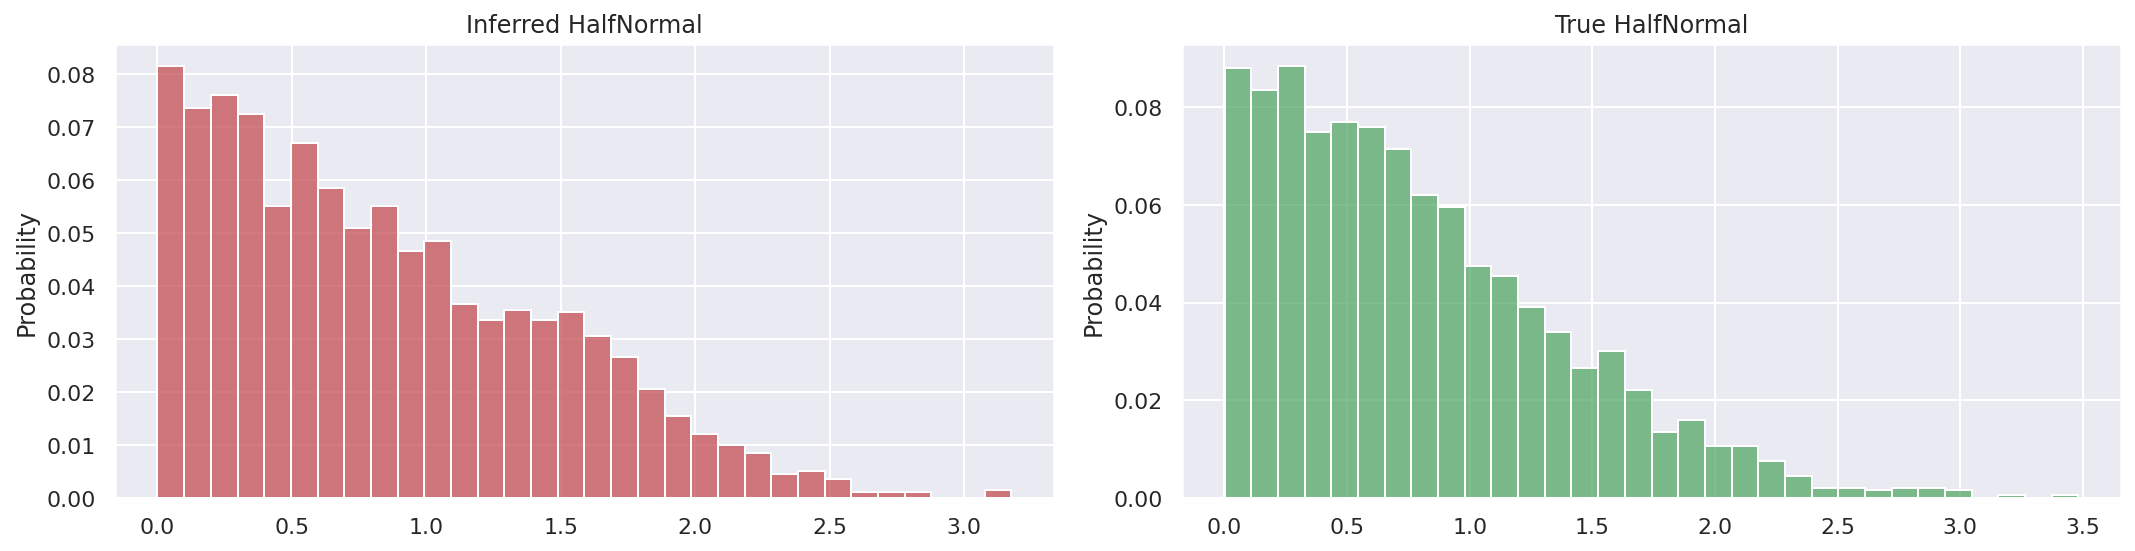

In [4]:
def model():
    """
    Model for HalfNormal(0, 1)
    
    The posterior on x will contain those values
    hat are more likely to result in a match between (x > 0) and samples from bernoulli.
    
    The Bernoulli's `p` can be thought of as a "predicate compliance parameter".
    """
    x = pyro.sample('x', dist.Normal(0, 1))
    predicate = (x > 0).float()
    obs = pyro.sample('obs', dist.Bernoulli(1.0), obs=predicate)


# Inference
pyro.clear_param_store()

kernel = NUTS(
    model, jit_compile=True, ignore_jit_warnings=True, max_tree_depth=5
)
posterior = MCMC(
    kernel, num_samples=2_000, warmup_steps=500
)
posterior.run()


# Visualize posterior
xs_post = posterior.get_samples()['x']
xs_true = dist.HalfNormal(1).sample(T.tensor([xs_post.size(0),]))

plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
sns.histplot(xs_post, stat='probability', color='r', bins=32)
plt.title('Inferred HalfNormal')
# plt.ylim([0, 0.11])

plt.subplot(1, 2, 2)
sns.histplot(xs_true, stat='probability', color='g', bins=32)
plt.title('True HalfNormal')
# plt.ylim([0, 0.11])

plt.tight_layout()

### `DiscreteUniform(a, b)` conditioned to `(i, j)`

Sample: 100%|████████████████████████████████████████| 3000/3000 [00:54, 54.71it/s, step size=4.50e-02, acc. prob=0.874]                                                                                                                      


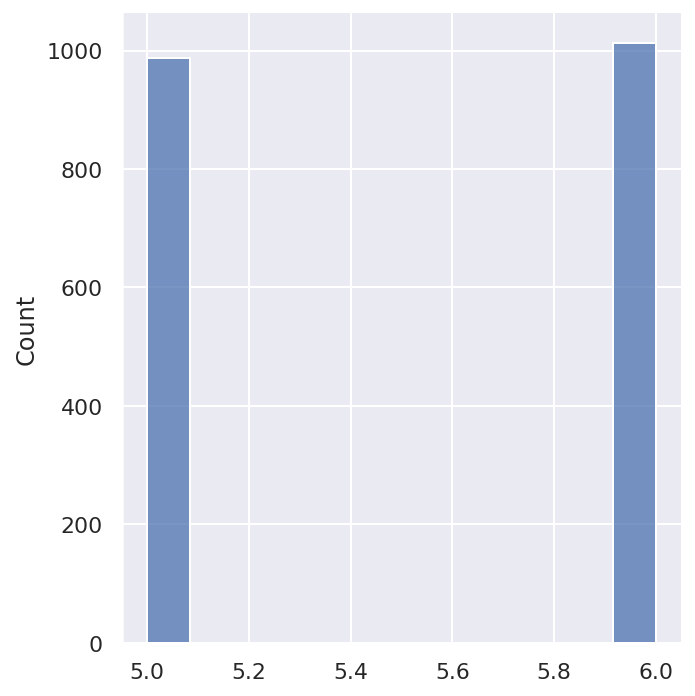

In [3]:
def model(a, b, i, j):
    """
    Model for DiscreteUniform(a, b) conditioned to (i, j)
    """
    x = (a + (b - a) * pyro.sample('x', dist.Uniform(0, 1))).long()
    predicate = ((x == i) | (x == j)).float()
    obs = pyro.sample('obs', dist.Bernoulli(1.0), obs=predicate)

    
a, b = (1, 10)
i, j = (5, 6)

# Inference
pyro.clear_param_store()

kernel = NUTS(
    model, jit_compile=True, ignore_jit_warnings=True, max_tree_depth=5
)
posterior = MCMC(
    kernel, num_samples=2_000, warmup_steps=1_000
)
posterior.run(a, b, i, j)


# Visualize posterior
xs_post = posterior.get_samples()['x']
xs_post = (a + (b - a) * xs_post).long()
sns.displot(xs_post)
pass